In [125]:
import numpy as np
from numpy.random import randn
from numpy.random import randint
import os
import cv2
import pandas as pd
import gzip
from matplotlib import pyplot as plt
from keras.preprocessing.image import load_img
from keras.datasets.mnist import load_data
from keras.preprocessing.image import img_to_array
from keras.optimizers import Adam
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.layers import Reshape
from keras.layers import Flatten
from keras.layers import Conv2D
from keras.layers import Conv2DTranspose
from keras.layers import LeakyReLU
from keras.layers import Dropout
from keras.layers import Embedding
from keras.layers import Concatenate


# define the standalone discriminator model
def define_discriminator(in_shape=(64,64,3), n_classes=2): # two calsses: -1 and 1
    # label input
    in_label = Input(shape=(40,)) # number of attr
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # scale up to image dimensions with linear activation
    n_nodes = in_shape[0] * in_shape[1]
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((in_shape[0], in_shape[1], 40))(li) # reshape to number of attr (64, 64, 40) in celeba
    # image input
    in_image = Input(shape=in_shape)
    # concat label as a channel
    merge = Concatenate()([in_image, li])
    
    # downsample
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same')(merge)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    # downsample
    fe = Conv2D(128, (4,4), strides=(2,2), padding='same')(fe)
    fe = LeakyReLU(alpha=0.2)(fe)
    
    # flatten feature maps
    fe = Flatten()(fe)
    # dropout
    fe = Dropout(0.4)(fe)
    # output
    out_layer = Dense(1, activation='sigmoid')(fe)
    # define model
    model = Model([in_image, in_label], out_layer)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

# define the standalone generator model
def define_generator(latent_dim, n_classes=2): # two calsses: -1 and 1
    # label input
    in_label = Input(shape=(40,)) # number of attr
    # embedding for categorical input
    li = Embedding(n_classes, 50)(in_label)
    # linear multiplication
    n_nodes = 4 * 4
    li = Dense(n_nodes)(li)
    # reshape to additional channel
    li = Reshape((4, 4, 40))(li) # reshape to number of attr (x, x, 40) in celeba
    # image generator input
    in_lat = Input(shape=(latent_dim,))
    # foundation for 7x7 image
    n_nodes = 128 * 4 * 4
    gen = Dense(n_nodes)(in_lat)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Reshape((4, 4, 128))(gen)
    # merge image gen and label input
    merge = Concatenate()([gen, li])
    # upsample to 14x14
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(merge)
    gen = LeakyReLU(alpha=0.2)(gen)
    # upsample to 28x28
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    gen = Conv2DTranspose(128, (4,4), strides=(2,2), padding='same')(gen)
    gen = LeakyReLU(alpha=0.2)(gen)
    # output
    out_layer = Conv2D(3, (4,4), activation='tanh', padding='same')(gen)
    # define model
    model = Model([in_lat, in_label], out_layer)
    return model

# define the combined generator and discriminator model, for updating the generator
def define_gan(g_model, d_model):
    # make weights in the discriminator not trainable
    d_model.trainable = False
    # get noise and label inputs from generator model
    gen_noise, gen_label = g_model.input
    # get image output from the generator model
    gen_output = g_model.output
    # connect image output and label input from generator as inputs to discriminator
    gan_output = d_model([gen_output, gen_label])
    # define gan model as taking noise and label and outputting a classification
    model = Model([gen_noise, gen_label], gan_output)
    # compile model
    opt = Adam(lr=0.0002, beta_1=0.5)
    model.compile(loss='binary_crossentropy', optimizer=opt)
    return model

In [147]:
def get_attributes(filename):
    attributes = pd.read_csv(filename)
    return np.array(attributes.drop('image_id', axis=1))[:how_many]

def load_dataset(dataset):
    X = []
    for i, myid in enumerate(dataset):
        image = load_img(directory + "/" + myid, target_size=img_shape[:2])
        image = (img_to_array(image) - 127.5) / 127.5 # from [0, 255] to [-1, 1]
        image = image[25:153, 45:173]
        image = cv2.resize(src=image, dsize=(64, 64))
        X.append(image)
    X = np.array(X)
    attributes = get_attributes(attr_file)
    attributes[attributes == -1] = 0 # replace label -1 to 0 for simplicity in generating random values later on
    return(X, attributes)

# select real samples
def generate_real_samples(dataset, n_samples):
    # split into images and labels
    images, labels = dataset
    # choose random instances
    ix = randint(0, images.shape[0], n_samples)
    # select images and labels
    X, labels = images[ix], labels[ix]
    # generate class labels
    y = np.ones((n_samples, 1))
    #print('X.shape: ', X.shape, 'labels.shape: ', labels.shape, 'y.shape: ', y.shape)
    return [X, labels], y

# generate points in latent space as input for the generator
def generate_latent_points(latent_dim, n_samples, n_classes=2): # two calsses: -1 and 1
    # generate points in the latent space
    x_input = randn(latent_dim * n_samples)
    # reshape into a batch of inputs for the network
    z_input = x_input.reshape(n_samples, latent_dim) # (64, 100)
    # generate labels
    labels = randint(0, n_classes, n_samples)
    for i in range(40-1): # attributes size
        labels2 = randint(0, n_classes, n_samples)
        labels = np.vstack((labels, labels2))
    return [z_input, labels.T]

# use the generator to generate n fake examples, with class labels
def generate_fake_samples(generator, latent_dim, n_samples):
    # generate points in latent space
    z_input, labels_input = generate_latent_points(latent_dim, n_samples)
    #print('z_input: ', z_input.shape, 'labels_input: ', labels_input.shape)
    # predict outputs
    images = generator.predict([z_input, labels_input])
    # create class labels
    y = np.zeros((n_samples, 1))
    #print('images: ', images.shape, 'labels_input: ', labels_input.shape, 'y: ', y.shape)
    return [images, labels_input], y

In [182]:
# train the generator and discriminator
def train(g_model, d_model, gan_model, dataset, latent_dim, n_epochs=5, n_batch=32):
    bat_per_epo = int(dataset[0].shape[0] / n_batch)
    half_batch = int(n_batch / 2)
    # manually enumerate epochs
    for i in range(n_epochs):
        # enumerate batches over the training set
        for j in range(bat_per_epo):
            # get randomly selected ✬real✬ samples
            [X_real, labels_real], y_real = generate_real_samples(dataset, half_batch)
            # update discriminator model weights
            d_loss1, _ = d_model.train_on_batch([X_real, labels_real], y_real)
            # generate ✬fake✬ examples
            
            [X_fake, labels], y_fake = generate_fake_samples(g_model, latent_dim, half_batch)
            # update discriminator model weights
            d_loss2, _ = d_model.train_on_batch([X_fake, labels], y_fake)
            # prepare points in latent space as input for the generator
            [z_input, labels_input] = generate_latent_points(latent_dim, n_batch)
            # create inverted labels for the fake samples
            y_gan = np.ones((n_batch, 1))
            # update the generator via the discriminator✬s error
            g_loss = gan_model.train_on_batch([z_input, labels_input], y_gan)
            
            # summarize loss on this batch
            print('>%d, %d/%d, d1=%.3f, d2=%.3f g=%.3f' % (i+1, j+1, bat_per_epo, d_loss1, d_loss2, g_loss))
        # save the generator model
        g_model.save('cgan_models/cgan_generator' +str(i+j)+'.h5')

In [184]:
directory = 'img_align_celeba/img_align_celeba/'
attr_file = 'list_attr_celeba.csv'
how_many = 25000
celeba_img = np.sort(os.listdir(directory))
dataset = celeba_img[:how_many]
img_shape = (178, 218, 3)

# size of the latent space
latent_dim = 100
# create the discriminator
d_model = define_discriminator()
# create the generator
g_model = define_generator(latent_dim)
# create the gan
gan_model = define_gan(g_model, d_model)
# load image data
#dataset = load_mnist('fash', kind='train')
dataset = load_dataset(dataset)

In [ ]:
# train model
train(g_model, d_model, gan_model, dataset, latent_dim);

>1, 1/781, d1=0.689, d2=0.697 g=0.691
>1, 2/781, d1=0.600, d2=0.700 g=0.689
>1, 3/781, d1=0.438, d2=0.709 g=0.682
>1, 4/781, d1=0.208, d2=0.738 g=0.663
>1, 5/781, d1=0.040, d2=0.785 g=0.656
>1, 6/781, d1=0.016, d2=0.812 g=0.672
>1, 7/781, d1=0.027, d2=0.760 g=0.693
>1, 8/781, d1=0.043, d2=0.710 g=0.719
>1, 9/781, d1=0.011, d2=0.657 g=0.782
>1, 10/781, d1=0.026, d2=0.612 g=0.877
>1, 11/781, d1=0.006, d2=0.560 g=0.998
>1, 12/781, d1=0.002, d2=0.503 g=1.154
>1, 13/781, d1=0.162, d2=0.520 g=0.987
>1, 14/781, d1=0.000, d2=0.477 g=1.138
>1, 15/781, d1=0.000, d2=0.363 g=1.522
>1, 16/781, d1=0.000, d2=0.204 g=2.382
>1, 17/781, d1=0.000, d2=0.074 g=3.587
>1, 18/781, d1=0.000, d2=0.033 g=4.574
>1, 19/781, d1=0.000, d2=0.324 g=7.283
>1, 20/781, d1=0.070, d2=0.010 g=7.797
>1, 21/781, d1=0.000, d2=1.021 g=21.639
>1, 22/781, d1=0.371, d2=0.000 g=22.974
>1, 23/781, d1=0.000, d2=0.000 g=18.102
>1, 24/781, d1=0.146, d2=0.000 g=11.602
>1, 25/781, d1=0.000, d2=0.000 g=9.609
>1, 26/781, d1=0.000, d2=0.000

>1, 208/781, d1=0.178, d2=0.033 g=5.386
>1, 209/781, d1=0.091, d2=0.029 g=5.048
>1, 210/781, d1=0.147, d2=0.119 g=6.100
>1, 211/781, d1=0.148, d2=0.019 g=5.853
>1, 212/781, d1=0.277, d2=0.588 g=9.049
>1, 213/781, d1=1.382, d2=0.082 g=3.335
>1, 214/781, d1=0.062, d2=0.770 g=7.567
>1, 215/781, d1=0.470, d2=0.009 g=6.133
>1, 216/781, d1=0.599, d2=1.809 g=6.359
>1, 217/781, d1=1.380, d2=0.008 g=5.196
>1, 218/781, d1=0.452, d2=0.032 g=3.646
>1, 219/781, d1=0.195, d2=0.042 g=3.480
>1, 220/781, d1=0.174, d2=0.036 g=3.391
>1, 221/781, d1=0.172, d2=0.042 g=3.391
>1, 222/781, d1=0.105, d2=0.045 g=3.522
>1, 223/781, d1=0.113, d2=0.036 g=3.508
>1, 224/781, d1=0.044, d2=0.034 g=3.979
>1, 225/781, d1=0.122, d2=0.032 g=3.891
>1, 226/781, d1=0.257, d2=0.085 g=3.465
>1, 227/781, d1=0.020, d2=0.047 g=3.744
>1, 228/781, d1=0.201, d2=0.202 g=3.606
>1, 229/781, d1=0.243, d2=0.348 g=4.492
>1, 230/781, d1=0.363, d2=0.064 g=4.117
>1, 231/781, d1=0.386, d2=0.277 g=5.927
>1, 232/781, d1=0.439, d2=0.005 g=6.189


>1, 413/781, d1=0.004, d2=0.047 g=9.696
>1, 414/781, d1=0.010, d2=0.016 g=9.222
>1, 415/781, d1=0.005, d2=0.001 g=10.383
>1, 416/781, d1=0.037, d2=0.058 g=9.326
>1, 417/781, d1=0.010, d2=0.003 g=9.679
>1, 418/781, d1=0.142, d2=0.139 g=9.396
>1, 419/781, d1=0.001, d2=0.023 g=9.321
>1, 420/781, d1=0.005, d2=0.003 g=10.065
>1, 421/781, d1=0.009, d2=0.001 g=9.438
>1, 422/781, d1=0.039, d2=0.023 g=7.961
>1, 423/781, d1=0.002, d2=0.003 g=8.042
>1, 424/781, d1=0.025, d2=0.000 g=7.463
>1, 425/781, d1=0.000, d2=0.296 g=9.831
>1, 426/781, d1=0.001, d2=0.009 g=10.158
>1, 427/781, d1=0.018, d2=0.096 g=10.982
>1, 428/781, d1=0.459, d2=0.050 g=8.115
>1, 429/781, d1=0.022, d2=0.002 g=6.692
>1, 430/781, d1=0.011, d2=0.009 g=7.465
>1, 431/781, d1=0.009, d2=0.050 g=6.910
>1, 432/781, d1=0.093, d2=0.088 g=9.054
>1, 433/781, d1=0.019, d2=0.011 g=10.495
>1, 434/781, d1=0.059, d2=0.064 g=11.300
>1, 435/781, d1=0.005, d2=0.004 g=11.326
>1, 436/781, d1=0.011, d2=0.071 g=11.438
>1, 437/781, d1=0.942, d2=0.040 

>1, 615/781, d1=0.004, d2=0.000 g=14.035
>1, 616/781, d1=0.128, d2=0.000 g=14.121
>1, 617/781, d1=0.004, d2=0.011 g=13.837
>1, 618/781, d1=0.011, d2=0.056 g=13.504
>1, 619/781, d1=0.002, d2=0.001 g=13.564
>1, 620/781, d1=0.002, d2=0.001 g=13.638
>1, 621/781, d1=0.013, d2=0.001 g=14.011
>1, 622/781, d1=0.003, d2=0.001 g=12.488
>1, 623/781, d1=0.055, d2=0.003 g=11.439
>1, 624/781, d1=0.003, d2=0.034 g=10.496
>1, 625/781, d1=0.006, d2=0.001 g=13.089
>1, 626/781, d1=0.001, d2=0.000 g=11.279
>1, 627/781, d1=0.004, d2=0.001 g=13.844
>1, 628/781, d1=0.002, d2=0.009 g=12.559
>1, 629/781, d1=0.023, d2=0.007 g=13.848
>1, 630/781, d1=0.001, d2=0.001 g=12.238
>1, 631/781, d1=0.001, d2=0.112 g=13.481
>1, 632/781, d1=0.000, d2=0.042 g=16.166
>1, 633/781, d1=0.016, d2=0.004 g=15.370
>1, 634/781, d1=0.009, d2=0.000 g=16.642
>1, 635/781, d1=0.021, d2=0.001 g=16.298
>1, 636/781, d1=0.001, d2=0.000 g=14.062
>1, 637/781, d1=0.051, d2=0.259 g=17.083
>1, 638/781, d1=0.108, d2=0.095 g=17.318
>1, 639/781, d1=

>2, 35/781, d1=0.002, d2=0.000 g=21.741
>2, 36/781, d1=0.057, d2=0.000 g=21.056
>2, 37/781, d1=0.016, d2=0.000 g=20.757
>2, 38/781, d1=0.023, d2=0.000 g=17.004
>2, 39/781, d1=0.000, d2=0.000 g=15.604
>2, 40/781, d1=0.001, d2=0.022 g=22.041
>2, 41/781, d1=0.014, d2=0.000 g=20.181
>2, 42/781, d1=0.022, d2=0.000 g=18.108
>2, 43/781, d1=0.063, d2=0.000 g=18.644
>2, 44/781, d1=0.000, d2=0.001 g=17.686
>2, 45/781, d1=0.000, d2=0.009 g=15.697
>2, 46/781, d1=0.003, d2=0.001 g=19.047
>2, 47/781, d1=0.001, d2=0.000 g=16.767
>2, 48/781, d1=0.004, d2=0.000 g=17.474
>2, 49/781, d1=0.002, d2=0.000 g=17.117
>2, 50/781, d1=0.000, d2=0.265 g=18.354
>2, 51/781, d1=0.012, d2=0.000 g=21.959
>2, 52/781, d1=0.217, d2=0.021 g=18.316
>2, 53/781, d1=0.003, d2=0.002 g=16.870
>2, 54/781, d1=0.000, d2=0.002 g=15.665
>2, 55/781, d1=0.000, d2=0.152 g=17.365
>2, 56/781, d1=0.004, d2=0.001 g=19.082
>2, 57/781, d1=0.008, d2=0.000 g=19.104
>2, 58/781, d1=0.002, d2=0.000 g=22.558
>2, 59/781, d1=0.004, d2=0.000 g=20.548


>2, 237/781, d1=0.000, d2=0.022 g=17.916
>2, 238/781, d1=0.004, d2=0.000 g=18.007
>2, 239/781, d1=0.001, d2=0.003 g=17.135
>2, 240/781, d1=0.012, d2=0.008 g=15.689
>2, 241/781, d1=0.000, d2=0.002 g=14.588
>2, 242/781, d1=0.008, d2=0.137 g=18.504
>2, 243/781, d1=0.003, d2=0.000 g=24.569
>2, 244/781, d1=0.003, d2=0.000 g=25.565
>2, 245/781, d1=0.015, d2=0.000 g=19.498
>2, 246/781, d1=0.019, d2=0.000 g=19.125
>2, 247/781, d1=0.094, d2=0.000 g=18.112
>2, 248/781, d1=0.000, d2=0.001 g=16.050
>2, 249/781, d1=0.075, d2=0.403 g=21.956
>2, 250/781, d1=0.001, d2=0.000 g=25.086
>2, 251/781, d1=0.011, d2=0.001 g=21.278
>2, 252/781, d1=0.047, d2=0.000 g=21.631
>2, 253/781, d1=0.000, d2=0.214 g=24.466
>2, 254/781, d1=0.005, d2=0.000 g=23.819
>2, 255/781, d1=0.006, d2=0.000 g=23.633
>2, 256/781, d1=0.030, d2=0.000 g=23.581
>2, 257/781, d1=0.227, d2=0.018 g=9.459
>2, 258/781, d1=0.001, d2=0.311 g=17.458
>2, 259/781, d1=0.003, d2=0.065 g=21.091
>2, 260/781, d1=0.080, d2=0.000 g=23.429
>2, 261/781, d1=0

>2, 437/781, d1=0.013, d2=0.000 g=20.779
>2, 438/781, d1=0.000, d2=0.000 g=22.207
>2, 439/781, d1=0.002, d2=0.006 g=21.049
>2, 440/781, d1=0.007, d2=0.000 g=19.754
>2, 441/781, d1=0.001, d2=0.002 g=18.889
>2, 442/781, d1=0.000, d2=0.006 g=17.681
>2, 443/781, d1=0.001, d2=0.000 g=17.259
>2, 444/781, d1=0.001, d2=0.000 g=22.287
>2, 445/781, d1=0.000, d2=0.002 g=16.982
>2, 446/781, d1=0.001, d2=0.000 g=20.283
>2, 447/781, d1=0.032, d2=0.000 g=19.591
>2, 448/781, d1=0.004, d2=0.092 g=18.523
>2, 449/781, d1=0.000, d2=0.000 g=19.972
>2, 450/781, d1=0.001, d2=0.000 g=18.876
>2, 451/781, d1=0.004, d2=0.021 g=21.351
>2, 452/781, d1=0.002, d2=0.042 g=23.057
>2, 453/781, d1=0.003, d2=0.000 g=25.463
>2, 454/781, d1=0.008, d2=0.000 g=22.098
>2, 455/781, d1=0.002, d2=0.000 g=26.032
>2, 456/781, d1=0.017, d2=0.000 g=23.823
>2, 457/781, d1=0.021, d2=0.163 g=24.255
>2, 458/781, d1=0.010, d2=0.000 g=27.233
>2, 459/781, d1=0.079, d2=0.000 g=18.399
>2, 460/781, d1=0.001, d2=0.000 g=20.164
>2, 461/781, d1=

>2, 637/781, d1=0.000, d2=0.013 g=19.491
>2, 638/781, d1=0.000, d2=0.021 g=19.247
>2, 639/781, d1=0.001, d2=0.000 g=21.857
>2, 640/781, d1=0.026, d2=0.001 g=20.971
>2, 641/781, d1=0.001, d2=0.000 g=20.525
>2, 642/781, d1=0.020, d2=0.000 g=20.193
>2, 643/781, d1=0.012, d2=0.000 g=22.326
>2, 644/781, d1=0.000, d2=0.000 g=22.565
>2, 645/781, d1=0.000, d2=0.000 g=21.403
>2, 646/781, d1=0.000, d2=0.046 g=21.780
>2, 647/781, d1=0.005, d2=0.097 g=26.695
>2, 648/781, d1=0.001, d2=0.000 g=23.012
>2, 649/781, d1=0.001, d2=0.000 g=26.528
>2, 650/781, d1=0.006, d2=0.000 g=26.994
>2, 651/781, d1=0.005, d2=0.000 g=27.339
>2, 652/781, d1=0.002, d2=0.000 g=24.990
>2, 653/781, d1=0.001, d2=0.000 g=24.764
>2, 654/781, d1=0.001, d2=0.000 g=22.996
>2, 655/781, d1=0.035, d2=0.000 g=20.937
>2, 656/781, d1=0.002, d2=0.000 g=21.879
>2, 657/781, d1=0.000, d2=0.000 g=24.853
>2, 658/781, d1=0.000, d2=0.001 g=21.293
>2, 659/781, d1=0.086, d2=0.060 g=22.266
>2, 660/781, d1=0.000, d2=0.008 g=23.013
>2, 661/781, d1=

>3, 58/781, d1=0.000, d2=0.004 g=22.791
>3, 59/781, d1=0.017, d2=0.000 g=23.892
>3, 60/781, d1=0.002, d2=0.001 g=22.952
>3, 61/781, d1=0.000, d2=0.002 g=27.410
>3, 62/781, d1=0.000, d2=0.218 g=25.914
>3, 63/781, d1=0.052, d2=0.000 g=28.548
>3, 64/781, d1=0.254, d2=0.004 g=18.217
>3, 65/781, d1=0.000, d2=0.004 g=17.618
>3, 66/781, d1=0.000, d2=0.359 g=19.611
>3, 67/781, d1=0.000, d2=0.055 g=18.528
>3, 68/781, d1=0.007, d2=0.000 g=22.697
>3, 69/781, d1=0.009, d2=0.000 g=22.523
>3, 70/781, d1=0.003, d2=0.000 g=19.583
>3, 71/781, d1=0.067, d2=0.000 g=17.095
>3, 72/781, d1=0.104, d2=0.000 g=17.061
>3, 73/781, d1=0.001, d2=0.046 g=17.520
>3, 74/781, d1=0.000, d2=0.001 g=19.272
>3, 75/781, d1=0.000, d2=0.001 g=18.438
>3, 76/781, d1=0.000, d2=0.000 g=19.829
>3, 77/781, d1=0.000, d2=0.000 g=15.867
>3, 78/781, d1=0.000, d2=0.000 g=18.267
>3, 79/781, d1=0.000, d2=0.000 g=18.210
>3, 80/781, d1=0.000, d2=0.082 g=21.298
>3, 81/781, d1=0.000, d2=0.000 g=22.462
>3, 82/781, d1=0.000, d2=0.000 g=21.536


>3, 259/781, d1=0.002, d2=0.000 g=24.118
>3, 260/781, d1=0.003, d2=0.000 g=22.192
>3, 261/781, d1=0.002, d2=0.004 g=27.501
>3, 262/781, d1=0.000, d2=0.108 g=24.446
>3, 263/781, d1=0.580, d2=0.029 g=11.144
>3, 264/781, d1=0.000, d2=0.068 g=12.185
>3, 265/781, d1=0.000, d2=0.078 g=12.767
>3, 266/781, d1=0.000, d2=0.000 g=11.510
>3, 267/781, d1=0.000, d2=0.029 g=14.501
>3, 268/781, d1=0.000, d2=0.000 g=13.465
>3, 269/781, d1=0.001, d2=0.002 g=14.768
>3, 270/781, d1=0.001, d2=0.007 g=16.026
>3, 271/781, d1=0.000, d2=0.000 g=15.400
>3, 272/781, d1=0.005, d2=0.098 g=18.557
>3, 273/781, d1=0.004, d2=0.004 g=18.019
>3, 274/781, d1=0.002, d2=0.000 g=16.140
>3, 275/781, d1=0.003, d2=0.000 g=18.460
>3, 276/781, d1=0.003, d2=0.000 g=19.923
>3, 277/781, d1=0.006, d2=0.000 g=18.851
>3, 278/781, d1=0.006, d2=0.000 g=16.036
>3, 279/781, d1=0.002, d2=0.004 g=16.679
>3, 280/781, d1=0.001, d2=0.000 g=21.055
>3, 281/781, d1=0.013, d2=0.000 g=17.585
>3, 282/781, d1=0.001, d2=0.000 g=14.942
>3, 283/781, d1=

In [179]:
# create and save a plot of generated images
def save_plot(examples, n):
    # plot images
    for i in range(n * n):
        # define subplot
        pyplot.subplot(n, n, 1 + i)
        # turn off axis
        pyplot.axis('off')
        # plot raw pixel data
        pyplot.imshow(examples[i, :, :, 0], cmap='gray_r')
    pyplot.show()

In [180]:
model = load_model('cgan_models/cgan_generator10.h5')

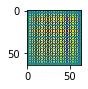

In [181]:
latent_points, labels = generate_latent_points(100, 1)
# specify labels
labels = np.zeros((1,40))
labels[0][9] = 1
# generate images
X = model.predict([latent_points, labels])
# scale from [-1,1] to [0,1]
X = (X + 1) / 2.0
# plot the result
plt.figure(figsize=(1,1))
pyplot.imshow(X[0, :, :, 0])